<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/plantseg_240112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlantSeg：顕微鏡染色画像の細胞インスタンス・セグメンテーション

<img src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/d9e2211b9f7ee3748313c79760ec852913449e62850677539cca9e381e1e9c09.png" alt="Image" style="background-color: white;">
plantsegの公式レポジトリより転載

## ライセンス
- 公式レポジトリ
    - https://github.com/hci-unihd/plant-seg/
    - MIT License
- Wolny, A. et al., (2020). Accurate and versatile 3D segmentation of plant tissues at cellular resolution. eLife, 9.  https://doi.org/10.7554/eLife.57613
    - CC-BY 4.0
- 公式データセット
    - https://osf.io/uzq3w/
    - Attribution to Wolny et al., 2020

## 解説
植物の細胞壁をなんらかの試薬で染色、もしくは蛍光タンパク質で光らせ、共焦点顕微鏡で撮影する状況があるとします。どんなに染色条件や顕微鏡の撮影条件を検討しても、染色ムラや光の散乱や減衰、さらには屈折率の不均一性などの理由で、均一に細胞壁を検出した画像を取得することは大変難しいことかと思います。もし均一に取ることができれば１視野にある無数の細胞の形を自動計測し、遺伝子の機能解析や発生モデルの構築などに役立てられるのに、現実はそうではなく、大変な補正作業が入ることが多いですね。

PlantSegは、共焦点顕微鏡やライトシート顕微鏡を用いて取得された3Dボリューム画像（2Dも可能です）における細胞インスタンスの認識を可能にするツールです​​。このツールは、主に植物細胞組織の染色画像に対してチューニングされており、訓練済みのモデルも提供されています​。

PlantSegは、2つのステップから構成されています​。

1. 細胞境界の予測：2D/3D U-Netを用い、細胞の境界領域を検出・抽出します。具体的には自家蛍光や染色由来のシグナル強度を均一化し、細胞壁の欠落やぼやけなど）を修正することができます​。
2. 細胞セグメンテーション：４種類の領域分割アルゴリズムが実装されています。
    - Multicut
    - GASP average
    - Mutex watershed
    - Distance transform watershed

PlantSegの出力フォーマットはHierarchical Data Format (HDF5)またはTagged Image File Format (TIFF)であり、本ソフトを前処理として活用した後、ilastik、MorphographX、Fijiといったよく使われる画像解析ソフトで引き続き解析を行うことが可能です。

## 環境構築
conda環境で実行する。

condacolabインストール後、mambaforgeのみインストール（anacondaのデフォルトチャンネルは一部有料ライセンスなので、可能な限りそれを使わないように考慮しています）

In [1]:
!pip install -q condacolab

import condacolab
condacolab.install_miniforge()

!conda update -y -q -n base conda
!conda config --show-sources

#実行後にセッションがクラッシュしますが、ランタイムが再起動するだけなので問題ありません。
#それまでに予約していたセッションは一旦切れてしまうので、もう一度実行し直す必要があります。

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    openssl-3.4.1              |       h7b32b05_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:

## 今回はConda環境でPlantseg v1.6.0を用います。

理由
1. 公式の環境設定ではmambaを利用します（#reference #https://kreshuklab.github.io/plant-seg/chapters/plantseg_legacy/installation/）が、mambaでは「-qをつけて実行しないと、実行結果部分の文字数が多くクラッシュする可能性がある」、「-qをつけると何をインストールしたのかわからない」ので、condaを利用します。

2. コマンドライン上での実行なので、公式に則り、GUIに特化したv2.xではなく、v1.xを用います。

3. v1.xの最新は1.8.1ですが、これを用いた場合、

  <details><summary>出力hdf5データの変換時</summary>
  ```python:
  file_path ="data/plantseg/PreProcessing/generic_confocal_3D_unet/N_294_final_crop_ds2_predictions.h5"
  data = {}
  with h5py.File(file_path, 'r') as file:
      def get_data_as_dict(name, obj):
          data[name] = file[name][:]
      file.visititems(get_data_as_dict)
  separator = '-' * 20
  print(data.keys())
  print(separator)
  for key, value in data.items():
      print(key, type(value))
      print(separator)
  for key, value in data.items():
      print(key, value.dtype, value.shape)
  ```
  </details>
  
  の出力が

  ```plaintext
  dict_keys(['predictions'])
  --------------------
  predictions <class 'numpy.ndarray'>
  --------------------
  predictions float32 (1, 320, 960, 1000)
  ```

  となってしまう。v1.6.0ではこれが生じず、```predictions float32 (320, 960, 1000)```と出力されるので、v1.6.0を選択しました。

In [1]:
# condaを用いたインストールに約8分かかります。

#plant-segの導入
!conda create -q -y -n plant-seg -c pytorch -c nvidia -c conda-forge python=3.10 pytorch pytorch-cuda=12.1 plant-seg=1.6.0 bioimageio.core

# Google Colabでは、環境構築してもactivateできないので、環境構築の時点で必要な依存ソフトウェアを導入して、
# 直接、その環境のbinにあるソフトウェアを起動する

BASE_DIR="/usr/local/envs/plant-seg/bin"
!{BASE_DIR}/plantseg --version

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/plant-seg

  added / updated specs:
    - bioimageio.core
    - plant-seg=1.6.0
    - python=3.10
    - pytorch
    - pytorch-cuda=12.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       3_kmp_llvm           7 KB  conda-forge
    adwaita-icon-theme-48.0    |           unix_0         596 KB  conda-forge
    affogato-0.3.3             |  py310h508ef9c_6         376 KB  conda-forge
    alabaster-1.0.0            |     pyhd8ed1ab_1          18 KB  conda-forge
    alsa-lib-1.2.13            |       hb9d3cd8_0         547 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_1          18 KB  conda-forge
    aom-3.9.1                  |       hac33072_0         2.6 MB  conda-forge
    ap

In [2]:
# torchのバージョンや、用いているcudaバージョンの確認
!{BASE_DIR}/python -c 'import torch; print(torch.__version__); print(torch.cuda.is_available()); print(torch.cuda.get_device_name(0)); print(torch.cuda.device_count()); print(torch.version.cuda)'

2.5.1
True
Tesla T4
1
12.1


## 解析対象データのダウンロードと確認
PlantSegを作成するために使われたtrain/validation/test datasetはOSF Homeにてホスティングされています<sup>3</sup>。ここからテストデータに使われた"3D confocal images of fixed *Arabidopsis thaliana* ovules"の１つをダウンロードします。

In [3]:
%cd /content/

/content


In [4]:
!mkdir -p data/plantseg

file_name = "data/plantseg/N_294_final_crop_ds2.h5"
!wget -O {file_name} https://osf.io/nk9em/download

--2025-03-25 02:22:50--  https://osf.io/nk9em/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/8jz7e/providers/osfstorage/5f86e7add85b70010f656acd?action=download&direct&version=1 [following]
--2025-03-25 02:22:50--  https://files.de-1.osf.io/v1/resources/8jz7e/providers/osfstorage/5f86e7add85b70010f656acd?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160874811 (153M) [application/octet-stream]
Saving to: ‘data/plantseg/N_294_final_crop_ds2.h5’

data/plantseg/N_294 100%[===================>] 153.42M  7.78MB/s    in 22s     

2025-03-25 02:23:14 (7.08 MB/s) - ‘data/plantseg/N_294_final_crop_ds2.h5’ saved [160874811/160874811]



In [5]:
# どのようなデータか可視化してみましょう
import h5py

raw_data = {}
with h5py.File(file_name, 'r') as file:
    def get_data_as_dict(name, obj):
        raw_data[name] = file[name][:]
    file.visititems(get_data_as_dict)

In [6]:
separator = '-' * 20 # 出力整理用

# 取得したデータにはlabel, label_with_ignore, rawというデータが格納されています。
print(raw_data.keys())
print(separator)

# それぞれのデータ型を確認すると、numpy arrayであることがわかります。
for key, value in raw_data.items():
    print(key, type(value))
print(separator)

# さらにnumpy array sizeは320,960,1000、縦320px,横960px,Z軸方向1000枚であり、
# ラベル情報はuint16、撮影画像はuint8のdtypeであることが確認できます。

for key, value in raw_data.items():
    print(key, value.dtype, value.shape)

dict_keys(['label', 'label_with_ignore', 'raw'])
--------------------
label <class 'numpy.ndarray'>
label_with_ignore <class 'numpy.ndarray'>
raw <class 'numpy.ndarray'>
--------------------
label uint16 (320, 960, 1000)
label_with_ignore int16 (320, 960, 1000)
raw uint8 (320, 960, 1000)


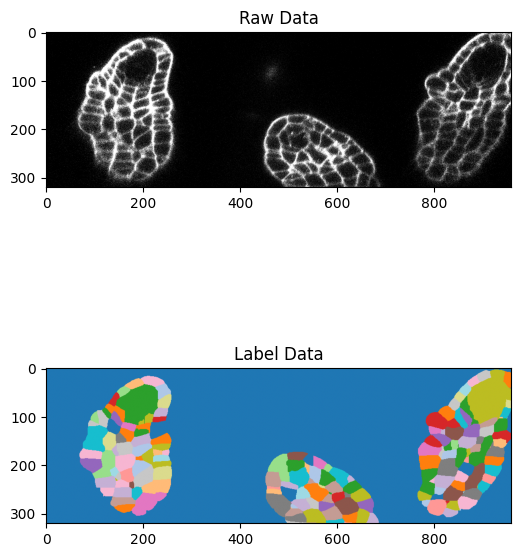

In [7]:
import matplotlib.pyplot as plt

# 100枚目の画像を表示してみます。
frame = 100

plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.title("Raw Data")
plt.imshow(raw_data["raw"][...,frame],cmap="gray")

plt.subplot(2,1,2)
plt.title("Label Data")
plt.imshow(raw_data["label"][...,frame],cmap="tab20")

# label with ignore dataの詳細がわからないため、ここでは無視します。詳細はレポジトリもしくは論文を参照してください。
# plt.subplot(3,1,3)
# plt.title("label_with_ignore data")
# plt.imshow(raw_data["label_with_ignore"][...,frame],cmap="tab20")

# plt.subplots_adjust()

## 解析


PlantSegはGUIを提供していますが、google colaboratoryでは使えないため、コマンドラインベースでの解析を行います。基本的な使い方として、必要な情報を全てyamlファイルに記述し、下記のように実行します。
```shell
plantseg --config config.yaml
```

公式レポジトリ<sup>1</sup>で提供されているexample yamlファイルを元に解析設定を定義しましょう。

In [8]:
# ColaboratoryのCPUのコア数を事前に調べます。
import multiprocessing
num_workers = multiprocessing.cpu_count()
print("Number of available workers:", num_workers)

Number of available workers: 8


In [9]:
%cd /content/

/content


In [10]:
import os
import yaml

# 既存の config.yaml ファイルがある場合のみ削除
if os.path.exists("config.yaml"):
    os.remove("config.yaml")

# 入力ファイルのパスを設定
INPUT_PATH = "data/plantseg/N_294_final_crop_ds2.h5"

data = {
    "path": INPUT_PATH,
    "preprocessing": {
        "state": True,
        "save_directory": "PreProcessing",
        "factor": [1.0, 1.0, 1.0],
        "order": 2,
        "crop_volume": "[:,:,:]",
        "filter": {
            "state": False,
            "type": "gaussian",
            "filter_param": 1.0
        }
    },
    "cnn_prediction": {
        "state": True,
        "model_name": "generic_confocal_3D_unet",
        "device": "cuda",
        "num_workers": 2,
        "patch": [100, 160, 160],
        "stride_ratio": 0.75,
        "model_update": False
    },
    "cnn_postprocessing": {
        "state": False,
        "tiff": False,
        "factor": [1, 1, 1],
        "order": 2
    },
    "segmentation": {
        "state": True,
        "name": "MutexWS",  # Google Colaboratory 無償版では MultiCUT 使用時にエラーが
                            # 出る場合があります。そのときは MultiCut を MutexWS に変更し
                            # て実行してください。
        "beta": 0.5,
        "save_directory": "MutexWS",
        "run_ws": True,
        "ws_2D": True,
        "ws_threshold": 0.5,
        "ws_minsize": 50,
        "ws_sigma": 2.0,
        "ws_w_sigma": 0,
        "post_minsize": 50
    },
    "segmentation_postprocessing": {
        "state": True,
        "tiff": False,
        "factor": [1, 1, 1],
        "order": 0,
        "save_raw": True
    }
}

with open('config.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)  # default_flow_style=False を追加して読みやすく

print("config.yamlファイルが正常に作成されました。")

config.yamlファイルが正常に作成されました。


## 推論

In [11]:
%cd /content/

/content


In [12]:
BASE_DIR="/usr/local/envs/plant-seg/bin"

!{BASE_DIR}/plantseg --config config.yaml

New version of PlantSeg available: 1.8.0.
Please update your version to the latest one!
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: 'patch_halo' is missing, plant-seg is trying to use a default.
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: patch_halo has got value: None, but value must be a list (or tuple). defaulting default value: [2, 4, 4]
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: 'output_type' is missing, plant-seg is trying to use a default.
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: output_type has got value: None, but value must be a string. defaulting default value: data_float32
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: 'save_raw' is missing, plant-seg is trying to use a default.
2025-03-25 02:23:23,433 [MainThread] WARNING PlantSeg - key: save_raw has got value: None, but value must be a bool. defaulting default value: False
2025-03-25 02:23:23,434 [MainThread] INFO PlantSeg - Running the 

## 結果の確認

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
%cd /content/

/content


In [15]:
# どのようなデータが得られたか可視化してみましょう
# 入力データと同様にhdf5の構造を確認します。

file_path ="data/plantseg/PreProcessing/generic_confocal_3D_unet/N_294_final_crop_ds2_predictions.h5"

data = {}
with h5py.File(file_path, 'r') as file:
    def get_data_as_dict(name, obj):
        data[name] = file[name][:]
    file.visititems(get_data_as_dict)

separator = '-' * 20

print(data.keys())
print(separator)

for key, value in data.items():
    print(key, type(value))
    print(separator)

for key, value in data.items():
    print(key, value.dtype, value.shape)

dict_keys(['predictions'])
--------------------
predictions <class 'numpy.ndarray'>
--------------------
predictions float32 (320, 960, 1000)


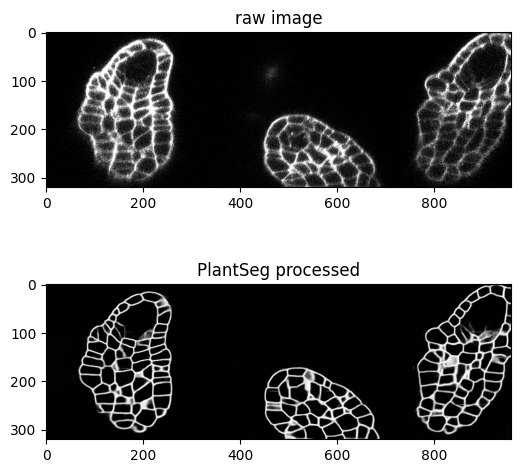

In [16]:
# 処理前と後を比べてみましょう
frame = 100
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.title("raw image")
plt.imshow(raw_data["raw"][...,frame],cmap="gray")
plt.subplot(2,1,2)
plt.title("PlantSeg processed")
plt.imshow(data["predictions"][...,frame], cmap="gray")

In [17]:
%cd /content/

/content


In [18]:
# 細胞のインスタンスセグメンテーション結果も見てみましょう。

file_path ="data/plantseg/PreProcessing/generic_confocal_3D_unet/MutexWS/N_294_final_crop_ds2_predictions_gasp_mutex_watershed.h5"

data = {}
with h5py.File(file_path, 'r') as file:
    def get_data_as_dict(name, obj):
        data[name] = file[name][:]
    file.visititems(get_data_as_dict)

separator = '-' * 20

print(data.keys())
print(separator)

for key, value in data.items():
    print(key, type(value))
print(separator)

for key, value in data.items():
    print(key, value.dtype, value.shape)

dict_keys(['segmentation'])
--------------------
segmentation <class 'numpy.ndarray'>
--------------------
segmentation uint16 (320, 960, 1000)


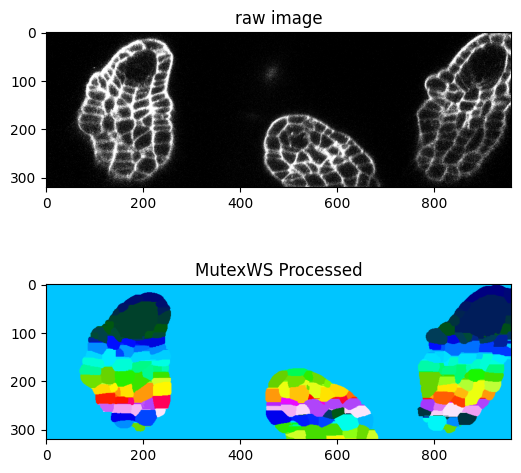

In [19]:
# 処理前と後を比べてみましょう
frame = 100
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.title("raw image")
plt.imshow(raw_data["raw"][...,frame],cmap="gray")
plt.subplot(2,1,2)
plt.title("MutexWS Processed")
plt.imshow(data["segmentation"][...,frame],cmap="gist_ncar")

## colaboratoryで三次元データ表示（おまけ1）

ImjoyPlugin（ImJoyプラットフォーム上でPythonやJavaScriptを用いてデータ解析やAIモデルの実行を可能にするプラグイン）でitk-vtk-viewerを利用した三次元データの可視化を、Google Colabのブラウザで実行できます。

参照元: [imjoyのテストノートブック](https://notebooks.gesis.org/binder/jupyter/user/imjoy-team-imjoy-binder-image-vu01sgoo/notebooks/imjoy-jupyter-tutorial.ipynb), [imjoyの公式doc](https://imjoy.io/docs/#/development?id=debugging)

## 1. imjoyをインストールする

In [22]:
%cd /content

/content


In [20]:
!pip install -qqq imjoy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 142.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 60.0 MB/s eta 0:00:00


## 2. 得られたhdf5とセグメンテーションデータを処理する

In [23]:
import numpy as np
from skimage.transform import rescale
import h5py

# 入力データと同様にhdf5の構造を確認します。
file_path = "data/plantseg/PreProcessing/generic_confocal_3D_unet/N_294_final_crop_ds2_predictions.h5"

with h5py.File(file_path, 'r') as file:
    images = file["predictions"][:]

# MutexWSが適用されたsegmented dataも準備します。
file_path2 = "data/plantseg/PreProcessing/generic_confocal_3D_unet/MutexWS/N_294_final_crop_ds2_predictions_gasp_mutex_watershed.h5"
with h5py.File(file_path2, 'r') as file:
    label_images = file["segmentation"][:]

# メモリとロード時間の節約、ブラウザの負荷軽減のため、画像サイズを小さくします。
scale = 1/4
images = np.array([rescale(x, (scale, scale), order=0, preserve_range=True, anti_aliasing=False) for x in images])
label_images = np.array([rescale(x, (scale, scale), order=0, preserve_range=True, anti_aliasing=False) for x in label_images])
# channel次元を足します。
# images = images[...,np.newaxis]
# label_images = label_images[...,np.newaxis]

# 処理後画像は0-1のrangeですので0-255のuint8型に変換します。
images *= 255.
images = images.astype(np.uint8)
# 同様に、label_imagesをuint16→uint8に変換します。
label_images = np.uint8((label_images / 65535) * 255)

print(images.shape)
print(label_images.shape)

(320, 240, 250)
(320, 240, 250)


## 3. Imjoyで表示する

  2セルに分けて実行する。（同一セル内で実行するとうまくいかない）
  
### 3-1. ImjoyPluginの準備

In [27]:
from imjoy import api

class ImJoyPlugin():
    def setup(self):
        api.log('plugin initialized')

# 設定完了
api.export(ImJoyPlugin())
print("imjoy pluginの設定が完了しました。次のセルでapt.createWindowを実行してください。")

imjoy pluginの設定が完了しました。次のセルでapt.createWindowを実行してください。


### 3-2. apt.createWindow実行

In [28]:
#apt.createWindowの実行
#ウィンドウサイズの幅指定ができるが、2025年3月現在、高さは指定できないので、ウィンドウを作成した後、マウスでウィンドウの高さを調節する。

api.createWindow(
    type="itk-vtk-viewer",
    src="https://oeway.github.io/itk-vtk-viewer/",
    data={"image_array": images, "label_image_array": label_images}, w="40" #w: width, h: height
)

<FuturePromise pending>



<img src=https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/5bd9b56168638d9970b953c25f3bcbed3cb35860e54e4e0e4fd4d2dca90158f8.png width=50%>


In [ ]:
%cd /content/

/content


## ImageJで解析しよう（おまけ２）
下のようなコードを書けばzipファイルでデータをダウンロードすることができ、例えばImageJ(Fiji)などで解析を続けることができます。

In [29]:
import os
from skimage.transform import rescale
from skimage.io import imsave

In [30]:
!mkdir -p segmentation

total_frame = data["segmentation"].shape[-1]
scale = 0.25

for i in range(total_frame):
    image = data["segmentation"][...,i].copy()
    name = str(i).zfill(5) + ".tiff"
    # optional rescaling
    image = rescale(image, (scale, scale), order=0, preserve_range=True, anti_aliasing=False)
    imsave(os.path.join("segmentation",name), image)
!zip -r segmentation.zip segmentation

/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00000.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00001.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00002.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00003.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00004.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmentation/00005.tiff is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/di

  adding: segmentation/ (stored 0%)
  adding: segmentation/00650.tiff (deflated 96%)
  adding: segmentation/00265.tiff (deflated 96%)
  adding: segmentation/00514.tiff (deflated 94%)
  adding: segmentation/00417.tiff (deflated 94%)
  adding: segmentation/00271.tiff (deflated 96%)
  adding: segmentation/00108.tiff (deflated 93%)
  adding: segmentation/00236.tiff (deflated 95%)
  adding: segmentation/00847.tiff (deflated 97%)
  adding: segmentation/00383.tiff (deflated 94%)
  adding: segmentation/00606.tiff (deflated 97%)
  adding: segmentation/00830.tiff (deflated 96%)
  adding: segmentation/00198.tiff (deflated 93%)
  adding: segmentation/00771.tiff (deflated 95%)
  adding: segmentation/00460.tiff (deflated 94%)
  adding: segmentation/00945.tiff (deflated 99%)
  adding: segmentation/00786.tiff (deflated 95%)
  adding: segmentation/00056.tiff (deflated 96%)
  adding: segmentation/00881.tiff (deflated 98%)
  adding: segmentation/00086.tiff (deflated 94%)
  adding: segmentation/00005.tiff

ImageJでスタックとして読み込み、別途解析が可能です。

![picture 0](https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/6f9842081ac7979f0f888174b9b437dd0c107c91d2f18b9cb8d6c885732bf27b.png)  
